In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from IPython.display import Image 

import math
import random
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [15]:
mu, sigma = 0, 0.08 # mean and standard deviation

s = np.random.normal(mu, sigma, 5).round(2)

print(s)

[-0.04 -0.08 -0.06  0.19 -0.09]


In [6]:
def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [4]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)


def show_gtemp(garr,ln,weight = None, mintemp = 26, maxtemp = 32):
    fig, axs = plt.subplots(ln, ln, figsize=(15, 15))
    amax = np.zeros((ln,ln))
    for n in range(ln**2):
        col = int(n/ln)
        row = int(n%ln)
        bicubic = griddata(points, garr[n].reshape(-1), (grid_x, grid_y), method='cubic')
        if np.any(weight) != None:
            wbicubic = griddata(points, weight[n].reshape(-1)*80, (grid_x, grid_y), method='cubic')/80
            wbicubic[wbicubic < 0] = 0
            wbicubic[wbicubic > 1] = 1
            bicubic = bicubic*(1-wbicubic) + np.amin(garr)*wbicubic
        ax = axs[col,row]
        pcm = ax.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
        ax.set_axis_off()
        amax[col,row] = np.amax(bicubic)
    
    fig.colorbar(pcm, ax= axs[:], fraction=0.0175,pad=0.02)

    plt.show()
    print(amax.round(2))

In [33]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def reg_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx))
    garr2 = garr.reshape((oy,ox))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)

        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature():
    ln = 6
    dis = 16
    x_train = np.zeros((4,dis,ln**2,100,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis)
    x_train = x_train.reshape(16,-1,100,8,8,1).transpose(1,0,2,3,4,5)
    print(x_train.shape)
    
    
    file_path = "amax.json"
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    arr_list= json.loads(obj_text)
    arr_ans = reg_interpolate(np.array(arr_list),4,4*(ln**2),16,4*(ln**2)).reshape(16,4,ln,ln)
    arr_ans = reg_interpolate(arr_ans.transpose(1,0,2,3),4,16*(ln**2),dis,16*(ln**2)).reshape(dis,16,ln**2).transpose(1,0,2)
#     print(np.mean(arr_ans))
#     print(np.amax(arr_ans))
#     print(np.amin(arr_ans))
    temp_arr = np.array([27.44472821, 26.27245937, 21.30507148, 18.32839891])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,16,dis,ln**2,100))
    y_train[0] = ((np.ones((100,16,dis,ln**2))*arr_ans).transpose(1,2,3,0)-29)/6
    y_train[1] = (np.ones((dis,ln**2,100,16))*temp_inter).transpose(3,0,1,2)/25 -1
    y_train[2] = (np.ones((16,ln**2,100,dis))*np.linspace(0.25,1.75,dis)).transpose(0,3,1,2)-1
    pos_x = np.array([np.arange(1/6,2,1/3),]*6)-1
    pos_y = pos_x.T
    y_train[3] = (np.ones((16,dis,100,ln**2))*pos_x.reshape(-1)).transpose(0,1,3,2)
    y_train[4] = (np.ones((16,dis,100,ln**2))*pos_y.reshape(-1)).transpose(0,1,3,2)
    y_train = y_train.reshape(5,16,-1,100).transpose(2,1,3,0)
    
    x_train2 = []
    y_train2 = []
    for k in range(16):
        for i in range(x_train.shape[0]):
            for j in range(i+1,x_train.shape[0]):
                
                _a = random.randint(0,99)
                _b = random.randint(0,99)
                _x = np.zeros((2,8,8,1))
                _x[0] = x_train[i,k,_a]
                _x[1] = x_train[j,k,_b]
                _x = np.amax(_x, axis = 0)
#                 if i == 0 and j == 5+k:
#                     show_temp(x_train[i,k,_a])
#                     show_temp(x_train[j,k,_b])
#                     show_temp(_x)
                x_train2.append(_x)
                x_train2.append(_x)
                
                #add noise
                mu, sigma = 0, 0.01 # mean and standard deviation
                _na = np.random.normal(mu, sigma, 5)
                _nb = np.random.normal(mu, sigma, 5)
                y_train2.append(y_train[i,k,_a])
                y_train2.append(y_train[j,k,_b])
            
    x_train2 = np.array(x_train2)
    y_train2 = np.array(y_train2)
    
    
    indices = np.arange(x_train2.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train2.shape[0]*0.2)
    ind_half = math.floor(ind*0.5)
    return x_train2[indices[:-ind]],y_train2[indices[:-ind],2:], y_train2[indices[:-ind],:2], x_train2[indices[-ind:-ind_half]], y_train2[indices[-ind:-ind_half],2:],y_train2[indices[-ind:-ind_half],:2], x_train2[indices[-ind_half:]], y_train2[indices[-ind_half:],2:], y_train2[indices[-ind_half:],:2]

In [34]:
x_train, x_train2, y_train, x_test, x_test2, y_test, x_val,x_val2, y_val = load_temperature()

# x_train.shape[0]

(576, 16, 100, 8, 8, 1)


In [35]:
print(x_train.shape)
print(x_train2.shape)
print(y_train.shape)

print(x_test.shape)
print(x_test2.shape)
print(y_test.shape)

print(x_val.shape)
print(x_val2.shape)
print(y_val.shape)

(4239360, 8, 8, 1)
(4239360, 3)
(4239360, 2)
(529920, 8, 8, 1)
(529920, 3)
(529920, 2)
(529920, 8, 8, 1)
(529920, 3)
(529920, 2)


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8, 8, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 8, 8, 64)     640         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 6, 6, 128)    73856       conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 3, 3, 128)    0           conv2d_13[0][0]                  
_______________________________________________________________________________________

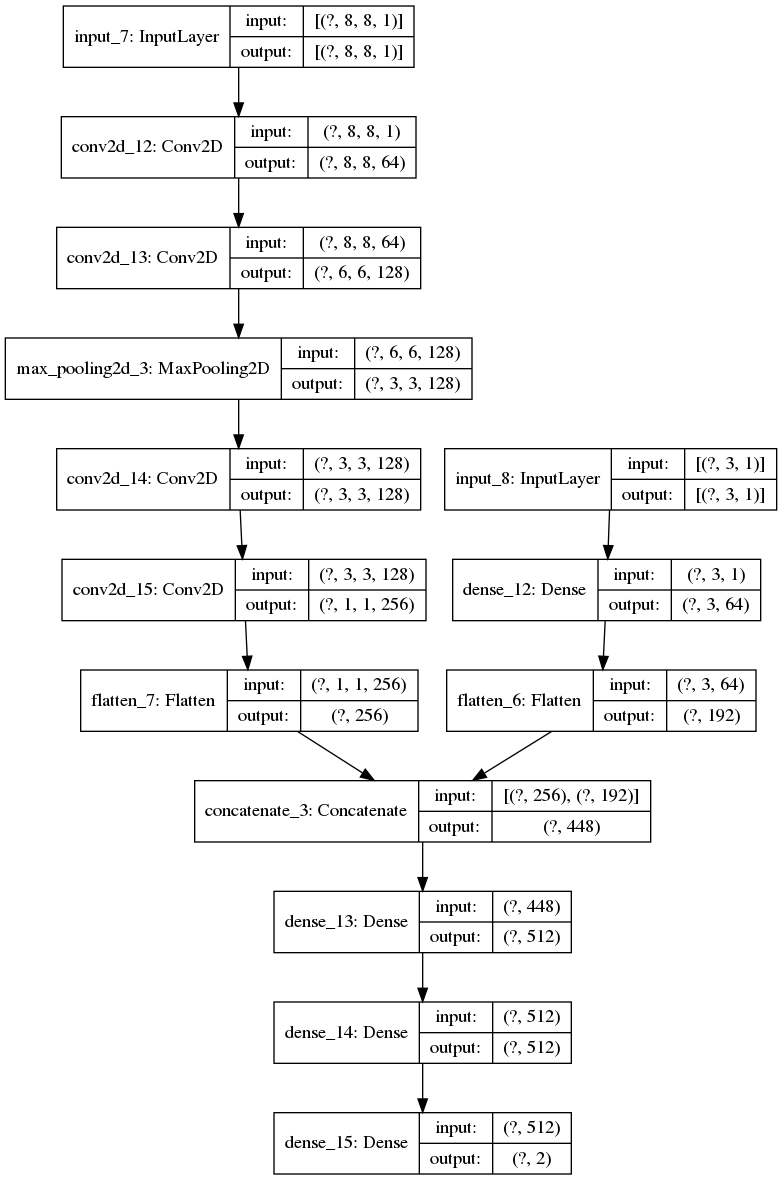

In [24]:
input_shape = (8,8,1)
input_shape2 = (3,1)
kernel_size = 3
filters = 64
dropout = 0.3

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
inputs2 = Input(shape=input_shape2)
# y = Dropout(0.2)(inputs)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           padding='same',
           activation='relu')(inputs)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
           activation='relu')(y)
y = MaxPooling2D()(y)

y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
           padding='same',
           activation='relu')(y)
y = Conv2D(filters=filters*4,
           kernel_size=kernel_size,
           activation='relu')(y)
# y = Dropout(dropout)(y)

y2 = Dense(filters, activation='relu')(inputs2)
y2 = Flatten()(y2)

# image to vector before connecting to dense layer
y = Flatten()(y)
y = Concatenate()([y,y2])
y = Dense(filters*8, activation='relu')(y)
y = Dense(filters*8, activation='relu')(y)
# dropout regularization
# y = Dropout(dropout)(y)
outputs = Dense(2, activation='tanh')(y)

# build the model by supplying inputs/outputs
model = Model(inputs=[inputs,inputs2], outputs=outputs)
# network model in text
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [25]:
opt = Adam(lr=0.0002, beta_1=0.5)
model.compile(loss='mse',
              optimizer= opt,
              metrics=['accuracy'])

batch_size = 256
history = model.fit([x_train,x_train2],
          y_train,
          validation_data=([x_test,x_test2], y_test),
          epochs=5,
          batch_size=batch_size)

score = model.evaluate([x_test,x_test2], y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
score = model.evaluate([x_val,x_val2], y_val, batch_size=batch_size)
print("\nValidation accuracy: %.1f%%" % (100.0 * score[1]))

Epoch 1/5
16560/16560 [==============================] - 56s 3ms/step - loss: 0.0015 - accuracy: 0.9700 - val_loss: 9.3439e-04 - val_accuracy: 0.9727
Epoch 2/5
16560/16560 [==============================] - 56s 3ms/step - loss: 3.3000e-04 - accuracy: 0.9809 - val_loss: 2.0546e-04 - val_accuracy: 0.9824
Epoch 3/5
16560/16560 [==============================] - 56s 3ms/step - loss: 3.1305e-04 - accuracy: 0.9815 - val_loss: 1.9021e-04 - val_accuracy: 0.9831
Epoch 4/5
16560/16560 [==============================] - 56s 3ms/step - loss: 2.4942e-04 - accuracy: 0.9823 - val_loss: 2.1485e-04 - val_accuracy: 0.9825
Epoch 5/5
2070/2070 [==============================] - 3s 1ms/step - loss: 1.7641e-04 - accuracy: 0.9838

Test accuracy: 98.4%
2070/2070 [==============================] - 3s 1ms/step - loss: 1.7626e-04 - accuracy: 0.9834

Validation accuracy: 98.3%


In [ ]:
score = model.evaluate([x_test,x_test2], y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
score = model.evaluate([x_val,x_val2], y_val, batch_size=batch_size)
print("\nValidation accuracy: %.1f%%" % (100.0 * score[1]))

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#log

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(1-np.array(history.history['accuracy']))
plt.plot(1-np.array(history.history['val_accuracy']))
plt.title('model negative log accuracy')
plt.ylabel('negative log accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()
# summarize history for log loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model log loss')
plt.ylabel('log loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

In [ ]:
(model.predict([x_test[:100], x_test2[:100]])*np.array([6,25])+np.array([27,25])).round(2)

In [ ]:
(y_test[:100]*np.array([6,25])+np.array([27,25])).round(2)

In [ ]:
abs((model.predict([x_test[:100], x_test2[:100]])*np.array([6,25])+np.array([27,25]))-(y_test[:100]*np.array([6,25])+np.array([27,25]))).round(2)

In [ ]:
np.median(abs((model.predict([x_test, x_test2])*np.array([6,25])+np.array([27,25]))-(y_test*np.array([6,25])+np.array([27,25]))),axis = 0)

In [ ]:
np.median(abs((model.predict([x_val, x_val2])*np.array([6,25])+np.array([27,25]))-(y_val*np.array([6,25])+np.array([27,25]))),axis = 0)

In [ ]:
model.save('my_model4.h5')

In [26]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([28.19163723, 26.99398514, 22.64881059, 19.28525343])
amb_dis = np.array([[ 2.2 ,  2.47,  2.44,  2.01],
       [ 0.62,  0.74,  1.  ,  1.84],
       [-1.85, -1.38, -0.35,  0.97],
       [-2.91, -3.16, -2.83, -1.81]])

for i in range(4):
    cubic = interp1d(dis_head, amb_dis[i], kind='cubic')
    poly_dis[i] = np.polyfit(dis_head,cubic(dis_head),3)
    
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    cubic = interp1d(amb_temp, amb_pts, kind='cubic')
    poly = np.polyfit(amb_temp,cubic(amb_temp),3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 7.19).round(2)

In [27]:
res = np.array(model.predict([x_test, x_test2])*np.array([6,25])+np.array([27,25]))

In [32]:
for i in range(100):
    print(res[i])

[28.74033415 25.33953367]
[29.17054027 26.94813367]
[27.43852597 20.15336454]
[26.18787771 19.10353452]
[28.34624612 26.32554546]
[27.69335032 25.29809265]
[26.31883813 21.27870135]
[29.42877835 26.94678791]
[25.88838065 20.62045261]
[29.87206417 27.12150272]
[27.45056024 23.93279029]
[25.76033986 18.29767823]
[28.1793488  21.28800787]
[28.29002345 26.26048466]
[29.27143711 26.43268323]
[26.88605192 19.58441623]
[26.17131624 19.61375438]
[25.78863198 18.36668774]
[29.13630474 26.23832477]
[29.72315794 27.38826871]
[28.6668123  26.64704043]
[28.35948184 21.31927311]
[29.10473657 26.6567193 ]
[26.01430374 18.72902215]
[25.72579685 18.97239871]
[25.56180543 20.72584927]
[28.32098633 26.33146271]
[26.21007916 22.24560045]
[28.03052017 25.33982852]
[28.81667036 23.06661196]
[29.72580278 27.41082516]
[25.55835459 18.9122308 ]
[25.73595116 21.30809128]
[28.69319665 24.36079471]
[28.24529645 23.37545883]
[29.42869145 27.38770805]
[26.5568777  19.56559308]
[28.88398415 26.5196681 ]
[29.31448996

In [36]:
for i in range(100):
    print(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]*2+2.5))

36.71
35.61
37.17
36.61
35.51
35.6
35.54
35.87
35.37
35.85
35.94
37.64
36.19
34.07
36.38
35.95
36.14
37.54
36.01
35.61
34.05
37.66
36.03
35.79
36.43
34.65
35.48
35.32
36.0
36.03
35.7
35.67
34.95
35.14
36.13
35.09
36.65
35.87
35.44
35.54
33.55
34.76
34.99
36.15
35.58
33.88
35.37
35.78
36.96
35.71
35.6
35.93
35.0
35.54
35.65
33.81
36.47
35.55
35.55
36.0
34.46
37.86
34.75
34.1
35.18
34.17
36.02
35.98
36.77
34.39
34.64
36.44
35.67
36.37
34.98
36.11
35.76
34.98
35.91
35.31
33.56
37.06
33.3
35.58
34.56
35.68
35.67
35.98
35.16
36.26
37.17
33.65
35.05
35.3
34.78
35.37
35.52
37.18
35.92
36.33


In [37]:
for i in range(100):
    print(get_bodytemp(y_test[i,0]*6+27,y_test[i,1]*25+25,x_test2[i,0]*2+2.5))

36.04
35.78
35.76
35.05
35.84
35.6
35.85
35.45
35.47
34.78
35.13
35.86
35.56
35.44
35.4
35.54
35.9
37.13
35.4
35.85
34.62
35.88
35.7
34.79
35.61
35.51
35.5
35.56
36.18
35.67
35.81
36.2
35.49
35.28
35.38
35.38
35.5
35.84
35.82
35.16
35.69
35.47
35.26
35.77
35.33
35.44
34.81
35.31
35.18
35.36
37.08
35.68
34.8
35.23
35.4
35.74
36.24
35.51
35.85
35.8
35.56
35.38
35.6
34.8
35.62
35.15
37.63
35.9
35.39
35.05
35.1
35.4
35.28
35.63
35.14
34.96
35.63
35.71
35.67
35.38
34.25
35.75
36.12
35.14
35.17
37.36
35.67
35.55
35.66
35.65
35.66
35.23
35.41
36.48
35.34
35.09
35.45
35.1
35.65
36.1


In [38]:
for i in range(100):
    print(abs(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]*2+2.5) - get_bodytemp(y_test[i,0]*6+27,y_test[i,1]*25+25,x_test2[i,0]*2+2.5)))

0.6700000000000017
0.1700000000000017
1.4100000000000037
1.5600000000000023
0.3300000000000054
0.0
0.3100000000000023
0.4199999999999946
0.10000000000000142
1.0700000000000003
0.8099999999999952
1.7800000000000011
0.6299999999999955
1.3699999999999974
0.980000000000004
0.4100000000000037
0.240000000000002
0.4099999999999966
0.6099999999999994
0.240000000000002
0.5700000000000003
1.779999999999994
0.3299999999999983
1.0
0.8200000000000003
0.8599999999999994
0.020000000000003126
0.240000000000002
0.17999999999999972
0.35999999999999943
0.10999999999999943
0.5300000000000011
0.5399999999999991
0.14000000000000057
0.75
0.28999999999999915
1.1499999999999986
0.02999999999999403
0.38000000000000256
0.38000000000000256
2.1400000000000006
0.7100000000000009
0.269999999999996
0.37999999999999545
0.25
1.5599999999999952
0.5599999999999952
0.46999999999999886
1.7800000000000011
0.3500000000000014
1.4799999999999969
0.25
0.20000000000000284
0.3100000000000023
0.25
1.9299999999999997
0.229999999999

In [41]:
def get_weight(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)
    
    weight = np.ones(diff.shape)
    for i in range(diff.shape[0]):
        n = 0
        n_skew = 10000
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.
        sort_diff = np.unique(bicubic)
        mode =  0
        start = 0
        for j in range(int(sort_diff.shape[0]/2)):
            num = bicubic[bicubic == sort_diff[j]].shape[0]
            if (num > mode):
                mode = num
                start = j
        for j in range(max(2,start),int(sort_diff.shape[0]/2)):
            t_skew = abs(st.skew(bicubic[bicubic < sort_diff[j]] ))
            if t_skew < n_skew:
                n_skew = t_skew
                n = sort_diff[j]
        weight[i,diff[i] >= n] = 0 
    
    return weight.reshape(-1,8,8)

def output_interpolate2(temp_path, ln2):
    bgpath = 'train/' + temp_path + '/output-empty/1.txt'
    interpol = np.zeros((4,ln2**2,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)
        arrbg = read_tempdata(100,bgpath)

        weight = get_weight(garr,arrbg)

        bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
#         bg_max += np.mean(bg_mean)
        bg_max = max(bg_max,np.max(bg_mean))

        garr2 = (garr.transpose(1,2,0) -bg_mean).transpose(2,0,1)
        interpol[i] = thermal_interpolate(garr2,ln,ln,ln2,ln2)
        ln -= 1
#     bg_max /= 4
    return interpol+bg_max

def full_interpolate():
    ln = 6
    interpol = np.zeros((4,4,ln**2,8,8))
#     super_interpol = np.zeros((4,ln**3,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        interpol[i] = output_interpolate2(temp_path[i],ln)
#         super_interpol[i] = thermal_interpolate(interpol[i],4,ln**2,ln,ln**2)
#     full_interpol = thermal_interpolate(super_interpol,3,ln**3,ln,ln**3).reshape(ln,ln,ln**2,8,8)
    
    amax = np.zeros((4,4,ln,ln))
    for amb in range(4):
        for layer in range(4):
            for n in range(ln**2):
                col = int(n/ln)
                row = int(n%ln)
                bicubic = griddata(points, interpol[amb,layer,n].reshape(-1), (grid_x, grid_y), method='cubic')
                amax[amb,layer,col,row] = np.amax(bicubic)
                
    return interpol, amax

In [42]:
interpol, amax = full_interpolate()

ValueError: operands could not be broadcast together with shapes (3600,64) (6400,) 